In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl

mpl.use("Cairo")  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import cloudpickle as pkl

import gumbi as gmb
from candas.test import QuantStudio

from sklearn.metrics import confusion_matrix
from scipy.integrate import trapz
from scipy.special import logit

import benchmarking as bench

import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / "data"
graph_pth = fig_pth / "graphics"
gen_pth = fig_pth / "generated"
graph_pth.mkdir(exist_ok=True)

In [2]:
plt.style.use('style.mplstyle')

%config InlineBackend.figure_format = 'retina'

from utils import savefig

# Figure Formatting

In [3]:
width = 2.365
height = 1.75
figsize = (width, height)
ticklabelsize = 6
labelsize = 6

mar_l = 0.4
mar_r = 0.05
mar_t = 0.05
mar_b = 0.375


def format_fig(
    fig, figsize=figsize, mar_l=mar_l, mar_r=mar_r, mar_t=mar_t, mar_b=mar_b, **kwargs
):
    """Adjust margins of subplots using figsize"""
    height, width = figsize
    fig.set_size_inches(figsize)

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        **kwargs
    )

    for ax in fig.get_axes():
        ax.tick_params(which="both", length=1.5, width=0.6, labelsize=8)

# Experimental Results

In [4]:
endpoints = pd.read_csv(data_pth / "JG073N Endpoints.csv").rename(
    columns={"SignalDifference": "FAM-HEX"}
)

ng1_endpoints = endpoints[
    (endpoints["IFI44L Copies"] > 0)
    & (endpoints["EMRI Copies"] > 0)
    & (endpoints["Material"] == "RNA")
    & (endpoints["ng RNA"] == 1)
]

patients_100ng = pd.read_csv(gen_pth / "JG073 Processed patient data.csv")
patients_1ng = patients_100ng.drop(columns=["FAM89A"]).assign(
    EMRI=patients_100ng.EMRI - 2, IFI44L=patients_100ng.IFI44L - 2
)

In [5]:
ng1_ds = gmb.DataSet(ng1_endpoints, outputs=["FAM-HEX"])
ng1_gp = gmb.GP(ng1_ds).fit(
    continuous_dims=["EMRI Copies", "IFI44L Copies"],
    linear_dims=["EMRI Copies", "IFI44L Copies"],
)

In [ ]:
import importlib as il

il.reload(bench)

obj = bench.Objective(
    ng1_gp, ng1_ds, patients_1ng, 2, gen_pth / "JG073 Logistic Regression Scores.csv"
)
obj.set_limits(pad=0)
obj.predict()
obj.set_limits(pad=0.1)
obj.predict()
obj.score_patients()
obj.build_roc();

array([[0.        , 0.        ],
       [0.05      , 0.        ],
       [0.1       , 0.        ],
       [0.15      , 0.        ],
       [0.2       , 0.        ],
       [0.25      , 0.        ],
       [0.3       , 0.        ],
       [0.35      , 0.        ],
       [0.4       , 0.        ],
       [0.4       , 0.04545455],
       [0.45      , 0.04545455],
       [0.5       , 0.04545455],
       [0.5       , 0.09090909],
       [0.55      , 0.09090909],
       [0.55      , 0.13636364],
       [0.6       , 0.13636364],
       [0.65      , 0.13636364],
       [0.7       , 0.13636364],
       [0.75      , 0.13636364],
       [0.75      , 0.18181818],
       [0.8       , 0.18181818],
       [0.8       , 0.22727273],
       [0.85      , 0.22727273],
       [0.9       , 0.22727273],
       [0.9       , 0.27272727],
       [0.9       , 0.31818182],
       [0.9       , 0.36363636],
       [0.9       , 0.40909091],
       [0.9       , 0.45454545],
       [0.9       , 0.5       ],
       [0.

In [7]:
LR_roc = []
scores = obj.LR_Scores["LR_Score_m"]
dxs = obj.LR_Scores["Diagnosis"]
thresholds = np.hstack([scores.min() - 1, sorted(scores.values), scores.max() + 1])
for thresh in thresholds:
    tn, fp, fn, tp = confusion_matrix(dxs == "Viral", scores <= thresh).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    LR_roc.append([tpr, fpr])

LR_auroc = trapz(np.array(LR_roc)[:, 0], np.array(LR_roc)[:, 1])

Saving fig_5B__angry_lemur in /home/john/projects/can-manuscript/fig_5__happy_jaguar/graphics: [.svg] [.png] done


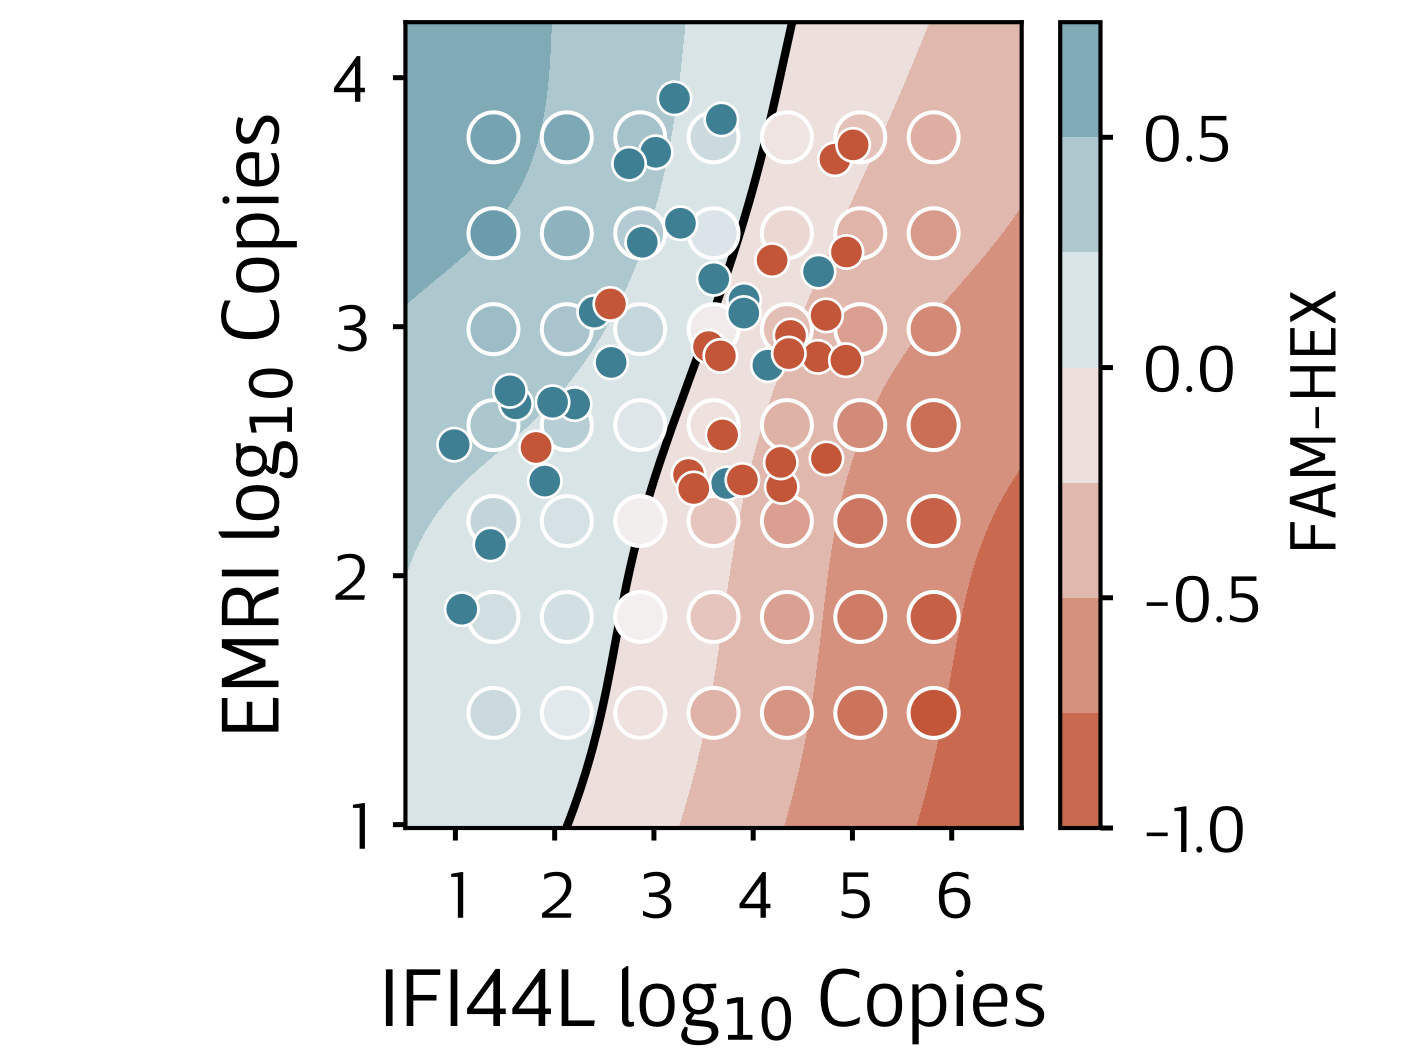

Saving fig_nan__calm_narwhal in /home/john/projects/can-manuscript/fig_5__happy_jaguar/graphics: [.svg] [.png] done


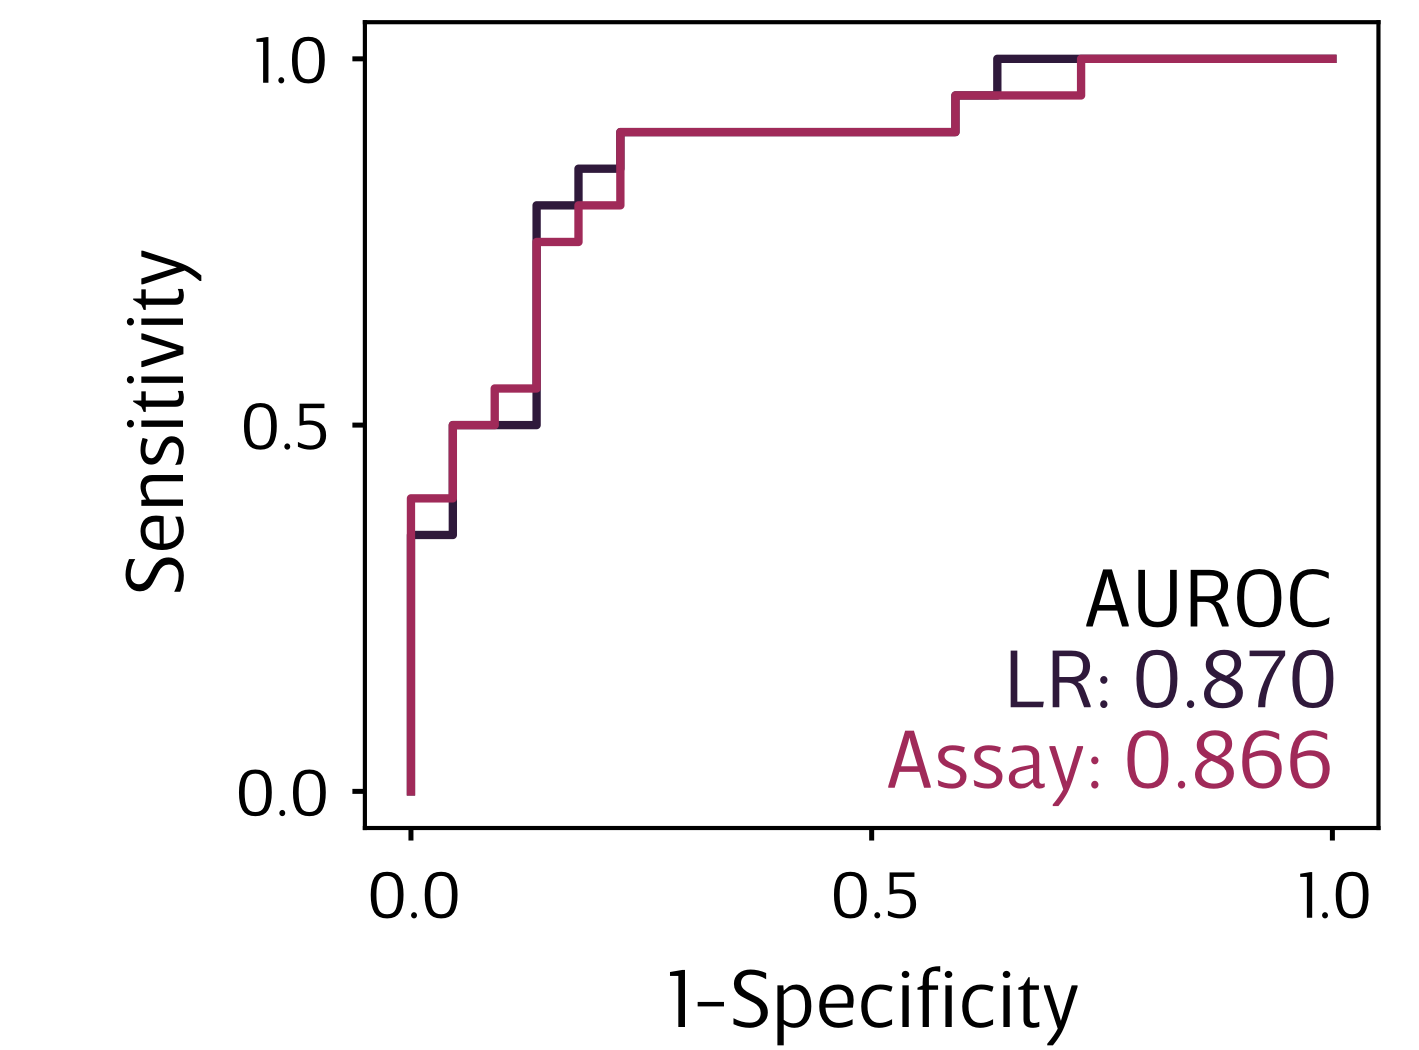

Saving fig_5C__excited_manatee in /home/john/projects/can-manuscript/fig_5__happy_jaguar/graphics: [.svg] [.png] done


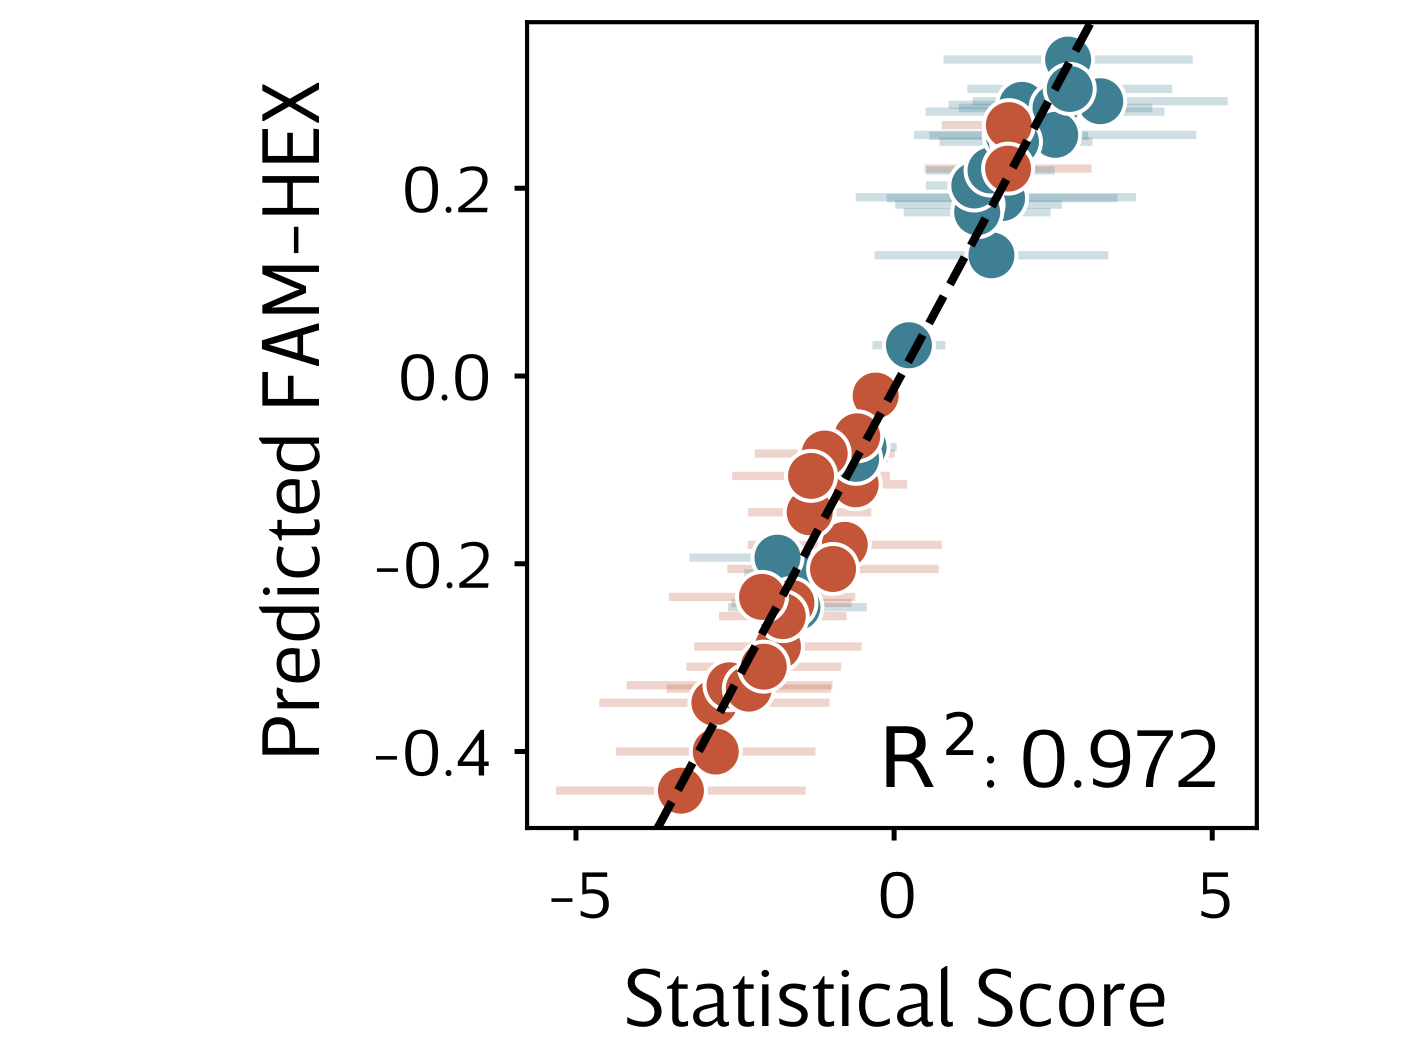

In [45]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
obj.set_limits(pad=0.1)
obj.predict()
pp = gmb.ParrayPlotter(
    x=obj.IFI44L_grid,
    y=obj.EMRI_grid,
    z=obj.sig,  # (obj.sig + 3 * obj.vshift) / obj.scale
)
pp(plt.contourf, cmap=obj.cmap, norm=mpl.colors.CenteredNorm(), zorder=-10)
cbar = pp.colorbar(ax=ax, ticks=[-1, -0.5, 0, 0.5, 1])
pp(plt.contour, levels=0, colors="k", norm=mpl.colors.CenteredNorm(), zorder=-5)
# cbar.set_label("")
cbar.ax.tick_params(labelsize=8)
obj.plot_observations(ax=ax, s=6**2)
obj.plot_patients(ax=ax, s=4**2)
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_ylabel('EMRI log$_{10}$ Copies')
ax.set_xlabel('IFI44L log$_{10}$ Copies')
cbar.set_label("FAM-HEX", fontsize=8)
format_fig(fig, figsize=figsize, mar_b=0.5, mar_l=0.5, mar_r=0.3)


savefig(fig, alias="angry_lemur", display_width_inches=0.5)

fig, ax = plt.subplots(1, 1, figsize=figsize)
LR_color = "#2F193B"
CAN_color = "#A02A59"
# Plot LR_roc
tpr_values, fpr_values = zip(*LR_roc)
ax.plot(fpr_values, tpr_values, color=LR_color)
ax.set_ylabel("Sensitivity")
ax.set_xlabel("1-Specificity")
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
format_fig(fig, figsize=figsize, mar_b=0.5, mar_l=0.45)

obj.plot_roc(ax=ax, color=CAN_color)
obj.roc["m"] = np.array(obj.roc["m"])
xl, yl = ax.get_xlim(), ax.get_ylim()

xy = (np.diff(xl) * 0.95 + xl[0], np.diff(yl) * 0.25 + yl[0])
ax.annotate("AUROC", xy=xy, ha="right", color="k")

xy = (np.diff(xl) * 0.95 + xl[0], np.diff(yl) * 0.15 + yl[0])
ax.annotate(f"LR: {LR_auroc:0.3f}", xy=xy, ha="right", color=LR_color)

xy = (np.diff(xl) * 0.95 + xl[0], np.diff(yl) * 0.05 + yl[0])
ax.annotate(f'Assay: {obj.auroc("m"):0.3f}', xy=xy, ha="right", color=CAN_color)

savefig(fig, alias="calm_narwhal", display_width_inches=0.5)

fig, ax = plt.subplots(1, 1, figsize=figsize)
obj.plot_comparison(
    ax=ax, scatter_kws={"s": 6**2}, line_kws={"alpha": 0.25, "zorder": -1}
)
ax.set_ylabel("Predicted FAM-HEX")
xl, yl = ax.get_xlim(), ax.get_ylim()
xy = (np.diff(xl) * 0.95 + xl[0], np.diff(yl) * 0.05 + yl[0])
ax.annotate(f"$R^2$: {obj.reg.rvalue**2:0.3f}", xy=xy, ha="right")
format_fig(fig, figsize=figsize, mar_b=0.5, mar_l=0.65, mar_r=0.2)


savefig(fig, alias="excited_manatee", display_width_inches=0.5)

# Logistic Regression

In [9]:
LR_rslt_file = gen_pth / "JG073 Bayesian Logistic Regression Results.pkl"

with open(LR_rslt_file, "rb") as buff:
    LR_results = pkl.load(buff)

lg10_Copies = LR_results["data"]
summary = LR_results["summary"]
per_gene_posterior_predictive = LR_results["per_gene_posterior_predictive"]
per_gene_posterior_summary_stats = LR_results["per_gene_posterior_summary_stats"]
per_gene_lines = LR_results["per_gene_lines"]

genes = list(per_gene_posterior_predictive.keys())

Saving fig_5A__sad_kiwi in /home/john/projects/can-manuscript/fig_5__happy_jaguar/graphics: [.svg] [.png] done


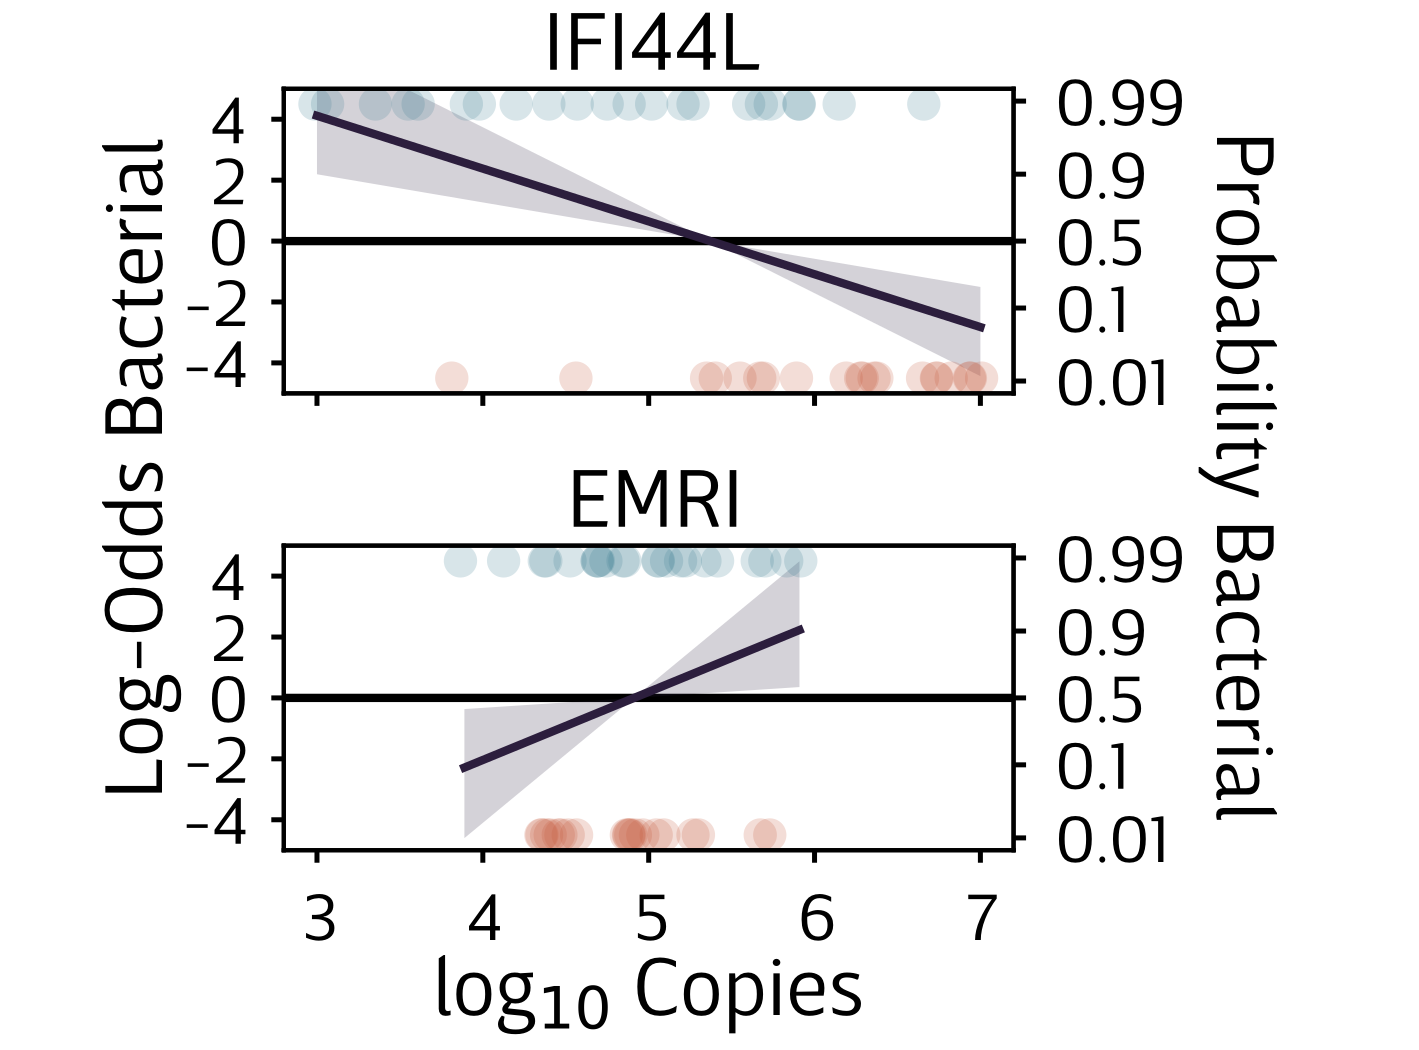

In [10]:
logit_max = 5
space = "log odds"
# figsize = (18, 4)
n_c = 100
copies = np.linspace(3, 7, n_c)
line_color = sns.color_palette("ch:0")[-1]

ymax = logit_max
yax1_ticks = np.arange(-(ymax), (ymax) + 0.1, 2.5)  # log-odds
yax1_ticks = [-4, -2, 0, 2, 4]  # log-odds
yax2_pts = np.array(
    [0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999]
)  # probabilities
yax2_ticks = logit(yax2_pts)
ylim = [-ymax, ymax]
yax1_label = ""  # 'Conditional\nLog Odds Dx'
yax2_label = ""  # 'Conditional\nProbability of Dx'
hline = 0

ax2s = []

fig, axs = plt.subplots(2, 1, figsize=figsize, sharex=True, sharey=True)
for i, g in enumerate(genes):
    ax = axs[i]
    ax.axhline(hline, color="k", zorder=0)

    plt.setp(
        ax,
        # title  = g,
        yticks=yax1_ticks,
        ylim=ylim,
        xticks=np.arange(copies.min(), copies.max() + 1),
        xlim=[
            copies[0] - (copies[-1] - copies[0]) * 0.05,
            copies[-1] + (copies[-1] - copies[0]) * 0.05,
        ],
    )
    ax.set_title(g, fontname="BreveSansText-Light", fontsize=10, pad=2)

    ax.set_ylabel(yax1_label)

    # For clarity, include a second yaxis that shows the marginal probability rather than log-odds
    ax2 = ax.twinx()
    ax2s.append(ax2)
    plt.setp(
        ax2,
        yticks=yax2_ticks,
        yticklabels=yax2_pts,
    )
    ax2.set_ylim(ax.get_ylim())
    ax2.set_ylabel(yax2_label, rotation=-90, verticalalignment="bottom")

# Plot patient data
for i, g in enumerate(genes):
    ax = axs[i]
    x = lg10_Copies[g]
    y = (lg10_Copies.Bacterial * 2 - 1) * (ymax - 0.5)

    high_color, low_color = sns.diverging_palette(220, 20, n=2)
    ax.plot(
        x[y < 0],
        y[y < 0],
        ls="none",
        marker="o",
        mfc=low_color,
        mec="none",
        ms=4,
        alpha=0.2,
    )
    ax.plot(
        x[y > 0],
        y[y > 0],
        ls="none",
        marker="o",
        mfc=high_color,
        mec="none",
        ms=4,
        alpha=0.2,
    )

for i, g in enumerate(genes):
    post = per_gene_posterior_predictive[g]

    lim = (copies > lg10_Copies[g].min()) & (copies < lg10_Copies[g].max())

    l, m, u = [np.percentile(post, p, axis=1) for p in [2.5, 50, 97.5]]
    axs[i].fill_between(copies[lim], l[lim], u[lim], alpha=0.2, facecolor=line_color)
    axs[i].plot(copies[lim], m[lim], color=line_color)
    # axs[i].plot(copies[lim], post[lim, :30], alpha=0.1, color=line_color)

axs[-1].set_xlabel("log$_{10}$ Copies", labelpad=0)

fig.text(
    0.1, 0.55, "Log-Odds Bacterial", ha="center", va="center", rotation="vertical"
)
fig.text(0.9, 0.55, "Probability Bacterial", ha="right", va="center", rotation=270)

# plt.tight_layout()
format_fig(fig, figsize=figsize, mar_l=0.35, mar_r=0.5, mar_t=0.2, mar_b=0.45, hspace=0.5)


savefig(fig, alias="sad_kiwi", display_width_inches=0.5)

# Clinical Results

In [11]:
width = 2.365
height = 1.75
figsize = (width, height)

In [12]:
cmax = 40

JG073Q = (
    QuantStudio(
        data_pth / "JG073Q Febrile Signature 1ng patient sample replicates.xlsx",
        "JG073Q",
    )
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore("HEX")
)

In [13]:
JG073Q.reactions.neaten()
JG073Q.extract_endpoints(cmax=cmax)
endpoints = JG073Q.endpoints

sample_data = pd.read_excel(data_pth / "JG073_RNA_JohnG_July_22.xlsx")

In [14]:
# List of letters from A to S
A_to_S = [a for a in "ABCDEFGHIJKLMNOPQRS"]

samples_1ng = endpoints[
    (endpoints.Target == "1ng_CAN_FAM") & (endpoints.Sample.isin(A_to_S))
].merge(sample_data, left_on="Sample", right_on="Code")

samples_1ng_ind = endpoints[
    (endpoints.Sample.isin(A_to_S)) & (endpoints.Target.isin(["IFI44L", "EMRI"]))
].merge(sample_data, left_on="Sample", right_on="Code")

IFI44L_1ng = samples_1ng_ind[samples_1ng_ind.Target == "IFI44L"][
    ["Phenotype", "Code", "CT"]
]
EMRI_1ng = samples_1ng_ind[samples_1ng_ind.Target == "EMRI"][
    ["Phenotype", "Code", "CT"]
]
CTs_1ng = pd.merge(
    IFI44L_1ng, EMRI_1ng, on=["Phenotype", "Code"], suffixes=("_IFI44L", "_EMRI")
)

## qPCR

In [15]:
palette = sns.diverging_palette(20, 220, n=2)

CTs = CTs_1ng.replace(
    {
        "Phenotype": {
            "Definite Bacterial": "Bacterial",
            "Definite Viral": "Viral",
        }
    }
).rename(columns={"CT_IFI44L": "IFI44L", "CT_EMRI": "EMRI", "Code": "Sample"})

CTs_mean = CTs.groupby(["Sample", "Phenotype"]).agg("mean")
CTs_sd = CTs.groupby(["Sample", "Phenotype"]).agg("std")
CTs_mean_sd = CTs.groupby(["Sample", "Phenotype"]).agg(["mean", "std"]).reset_index()
CTs_mean_sd.columns = [
    "_".join([n for n in tpl if n != ""]) for tpl in CTs_mean_sd.columns.to_flat_index()
]

In [16]:
# Use pymc3 to perform logistic regression to distinguish the Phenotype of patients in CTs_mean_sd given the means and standard deviations of the variables EMRI and IFI44L for each patient. Don't forget to take into account the uncertainties in the predictor measurements.
import pymc3 as pm
import theano.tensor as tt

# Prepare the data
X_mean = CTs_mean_sd[["IFI44L_mean", "EMRI_mean"]].values
X_sd = CTs_mean_sd[["IFI44L_std", "EMRI_std"]].values
y = (
    CTs_mean_sd["Phenotype"].map({"Viral": 0, "Bacterial": 1}).values
)  # Encode labels as 0 and 1

# Define the PyMC3 model
with pm.Model() as logistic_model:
    # Priors for coefficients and intercept
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    intercept = pm.Normal("intercept", mu=0, sigma=10)

    # Latent variables for predictors with uncertainty
    X_obs = pm.Normal("X_obs", mu=X_mean, sigma=X_sd, shape=X_mean.shape)

    # Logistic regression
    logits = tt.dot(X_obs, beta) + intercept
    p = pm.math.sigmoid(logits)

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Sample from the posterior
    idata = pm.sample(2000, tune=1000, return_inferencedata=True)

# Summarize the results
pm.summary(idata)

# from sklearn.linear_model import LogisticRegression

# df = CTs.groupby(["Sample", "Phenotype"]).agg("mean").reset_index()

# # Prepare the data
# X = df[["IFI44L", "EMRI"]]
# y = df["Phenotype"].map({"Viral": 0, "Bacterial": 1})  # Encode labels as 0 and 1

# # Fit logistic regression
# log_reg = LogisticRegression()
# log_reg.fit(X, y)

# # Coefficients for the separatrix
ifi44l_coef = (
    idata.posterior["beta"].sel(beta_dim_0=0).values.mean()
)  # log_reg.coef_[0, 0]
emri_coef = (
    idata.posterior["beta"].sel(beta_dim_0=1).values.mean()
)  # log_reg.coef_[0, 1]
intercept = idata.posterior["intercept"].values.mean()  # log_reg.intercept_[0]


# Equation of the separatrix: coef[0] * EMRI + coef[1] * IFI44L + intercept = 0
def decision_boundary(ifi44l):
    return -(ifi44l_coef * ifi44l + intercept) / emri_coef

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [X_obs, intercept, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.
The number of effective samples is smaller than 25% for some parameters.


Saving fig_5D__nervous_octopus in /home/john/projects/can-manuscript/fig_5__happy_jaguar/graphics: [.svg] [.png] done


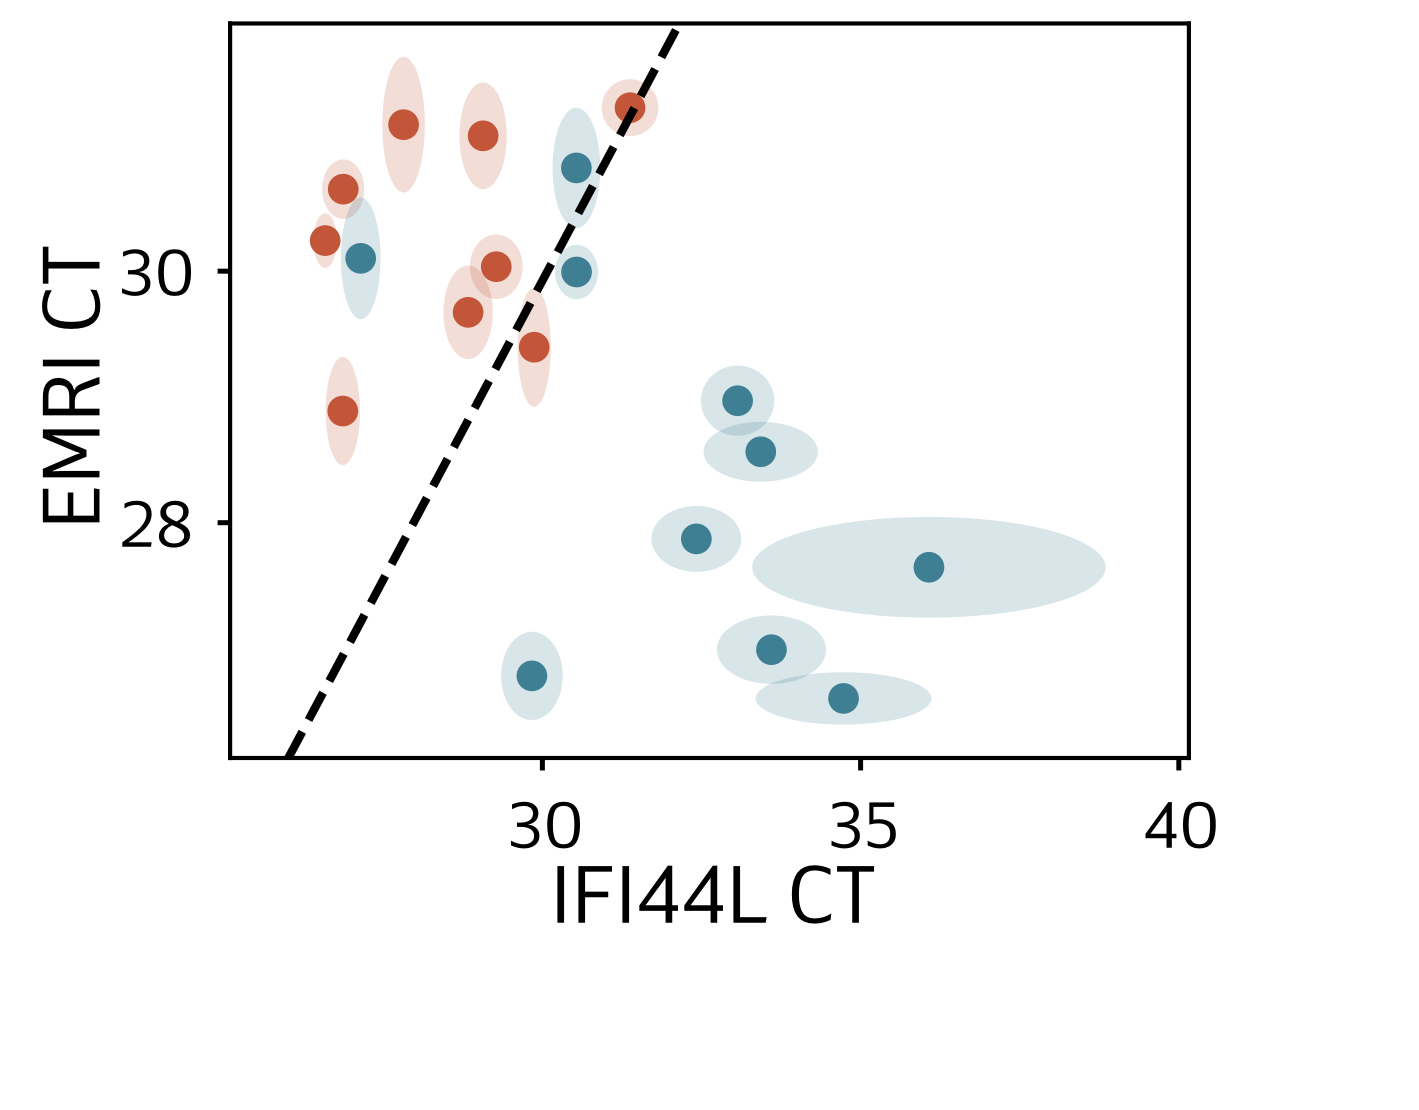

In [17]:
l_ = (CTs_mean - 1.96 * CTs_sd).reset_index()
u_ = (CTs_mean + 1.96 * CTs_sd).reset_index()
# CTs_mean = CTs_mean.reset_index()

fig = plt.figure()

ax = sns.scatterplot(
    data=(CTs.groupby(["Sample", "Phenotype"]).agg("mean")),
    x="IFI44L",
    y="EMRI",
    hue="Phenotype",
    hue_order=["Viral", "Bacterial"],
    palette=palette,
    s=4**2,
)
plt.legend().remove()


from matplotlib.patches import Ellipse, Rectangle

for Dx, color in zip(["Viral", "Bacterial"], palette):
    l = l_[l_.Phenotype == Dx]
    c = CTs_mean.reset_index()[CTs_mean.reset_index().Phenotype == Dx]
    u = u_[u_.Phenotype == Dx]

    for sample in c.Sample.unique():
        for sdm in [1]:
            ellipse = Ellipse(
                xy=(
                    c[c.Sample == sample].IFI44L.values,
                    c[c.Sample == sample].EMRI.values,
                ),
                width=(
                    u[u.Sample == sample].IFI44L - l[l.Sample == sample].IFI44L
                ).values
                * sdm,
                height=(u[u.Sample == sample].EMRI - l[l.Sample == sample].EMRI).values
                * sdm,
                fc=color,
                alpha=0.2,
            )
            ax.add_patch(ellipse)

xl = ax.get_xlim()
yl = ax.get_ylim()
db_ifi44l = np.linspace(*xl, 10)
db_emri = decision_boundary(db_ifi44l)
ax.plot(db_ifi44l, db_emri, "k--")
ax.set_ylim(yl)

# ax.set_title("Standard qPCR CTs", fontname="BreveSansText-Light", fontsize=10, pad=2)
ax.set_xlabel("IFI44L CT", labelpad=0)
ax.set_ylabel("EMRI CT", labelpad=0)
format_fig(fig, figsize=(width, height+0.1), mar_l=0.3, mar_r=0.3, mar_t=0.05, mar_b=0.75)

savefig(fig, alias="nervous_octopus", display_width_inches=0.5)

In [18]:
def euclidean_distance_to_line_with_uncertainty(row):
    x_point = row["IFI44L_mean"]
    y_point = row["EMRI_mean"]
    x_sd = row["IFI44L_std"]
    y_sd = row["EMRI_std"]

    # Coefficients of the line (ax + by + c = 0)
    a = ifi44l_coef
    b = emri_coef
    c = intercept

    # Calculate signed distance
    distance = (a * x_point + b * y_point + c) / np.sqrt(a**2 + b**2)

    # Uncertainty in distance calculation
    distance_sd = np.sqrt((a * x_sd) ** 2 + (b * y_sd) ** 2) / np.sqrt(a**2 + b**2)

    return pd.Series([distance, distance_sd], index=["distance", "distance_sd"])


distances = CTs_mean_sd.apply(euclidean_distance_to_line_with_uncertainty, axis=1)
CTs_mean_sd = pd.concat([CTs_mean_sd, distances], axis=1)

CTs_mean_sd["distance_lower"] = (
    CTs_mean_sd["distance"] - 1.96 * CTs_mean_sd["distance_sd"]
)
CTs_mean_sd["distance_upper"] = (
    CTs_mean_sd["distance"] + 1.96 * CTs_mean_sd["distance_sd"]
)

CTs_mean_sd

,Sample,Phenotype,IFI44L_mean,IFI44L_std,EMRI_mean,EMRI_std,distance,distance_sd,distance_lower,distance_upper
0,A,Bacterial,30.534205,0.191296,30.820684,0.244400,-0.282190,0.220794,-0.714945,0.150566
1,B,Bacterial,29.835340,0.246822,26.782316,0.179035,2.163441,0.213904,1.744189,2.582693
2,C,Viral,26.871008,0.168934,30.651801,0.120768,-2.683483,0.145629,-2.968916,-2.398050
3,D,Viral,29.275542,0.211926,30.035341,0.130961,-0.580092,0.174148,-0.921422,-0.238763
4,E,Viral,31.377624,0.227398,31.299610,0.115497,-0.048266,0.177627,-0.396415,0.299883
5,F,Viral,28.833042,0.197552,29.672549,0.189849,-0.621986,0.193543,-1.001331,-0.242641
6,G,Viral,29.069217,0.189507,31.075829,0.216492,-1.476406,0.204129,-1.876500,-1.076313
7,H,Bacterial,30.536942,0.172318,29.993226,0.110493,0.319457,0.143205,0.038776,0.600138
8,I,Viral,27.818989,0.170524,31.164441,0.275129,-2.401960,0.231452,-2.855605,-1.948314
9,J,Bacterial,32.419534,0.359982,27.871342,0.133455,3.154430,0.266201,2.632676,3.676184


In [19]:
fig = plt.figure()

samples = samples_1ng.replace(
    {
        "Phenotype": {
            "Definite Bacterial": "Bacterial",
            "Definite Viral": "Viral",
        }
    }
)

mn, mx = (
    samples.groupby(["Sample", "Phenotype"])["SignalDifference"]
    .agg("mean")
    .describe()
    .loc[["min", "max"]]
)

# normalize = lambda x: 0.5 - 3.5 * ((x - mn) / (mx - mn) * 2 - 1)


# samples.loc[:, "SignalDifference"] = normalize(samples.SignalDifference)

# Max-min normalize Signaldifference to -3 to 4
# can_means['SignalDifference'] = 0.5-3.5*((can_means['SignalDifference'] - can_means['SignalDifference'].min()) / (can_means['SignalDifference'].max() - can_means['SignalDifference'].min())*2-1)

can_means = (
    samples.groupby(["Sample", "Phenotype"])["SignalDifference"]
    .agg("mean")
    .reset_index()
)

μ = can_means.SignalDifference.mean()
σ2 = can_means.SignalDifference.std()

ax.set_ylabel("FAM-HEX")
can_means.SignalDifference = (can_means.SignalDifference - μ) / σ2

can_stds = (
    samples.groupby(["Sample", "Phenotype"])["SignalDifference"]
    .agg("std")
    .reset_index()
)

can_stds.SignalDifference /= σ2

sort_idx = can_means.SignalDifference.argsort()[::-1]
sample_order = can_means.loc[sort_idx, "Sample"]

can_means = can_means.set_index("Sample").loc[sample_order].reset_index()
can_stds = can_stds.set_index("Sample").loc[sample_order].reset_index()

In [20]:
# Use pymc3 to perform logistic regression to distinguish the Phenotype of patients in CTs_mean_sd given the means and standard deviations of the variables EMRI and IFI44L for each patient. Don't forget to take into account the uncertainties in the predictor measurements.
import pymc3 as pm
import theano.tensor as tt

# Prepare the data
X_mean = can_means.SignalDifference.values
X_sd = can_stds.SignalDifference.values
y = (
    can_means["Phenotype"].map({"Viral": 0, "Bacterial": 1}).values
)  # Encode labels as 0 and 1

# Define the PyMC3 model
with pm.Model() as can_logistic_model:
    # Priors for coefficients and intercept
    beta = pm.Normal("beta", mu=0, sigma=10)
    can_intercept = pm.Normal("intercept", mu=0, sigma=10)

    # Latent variables for predictors with uncertainty
    X_obs = pm.Normal("X_obs", mu=X_mean, sigma=X_sd, shape=X_mean.shape)

    # Logistic regression
    logits = X_obs * beta + intercept
    p = pm.math.sigmoid(logits)

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    # Sample from the posterior
    can_idata = pm.sample(2000, tune=1000, return_inferencedata=True)

# Summarize the results
pm.summary(can_idata)

can_boundary = -(
    can_idata.posterior["intercept"].values / can_idata.posterior["beta"].values
).mean()
can_boundary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [X_obs, intercept, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


0.07606644890751244

Saving fig_nan__bold_pheasant in /home/john/projects/can-manuscript/fig_5__happy_jaguar/graphics: [.svg] [.png] done


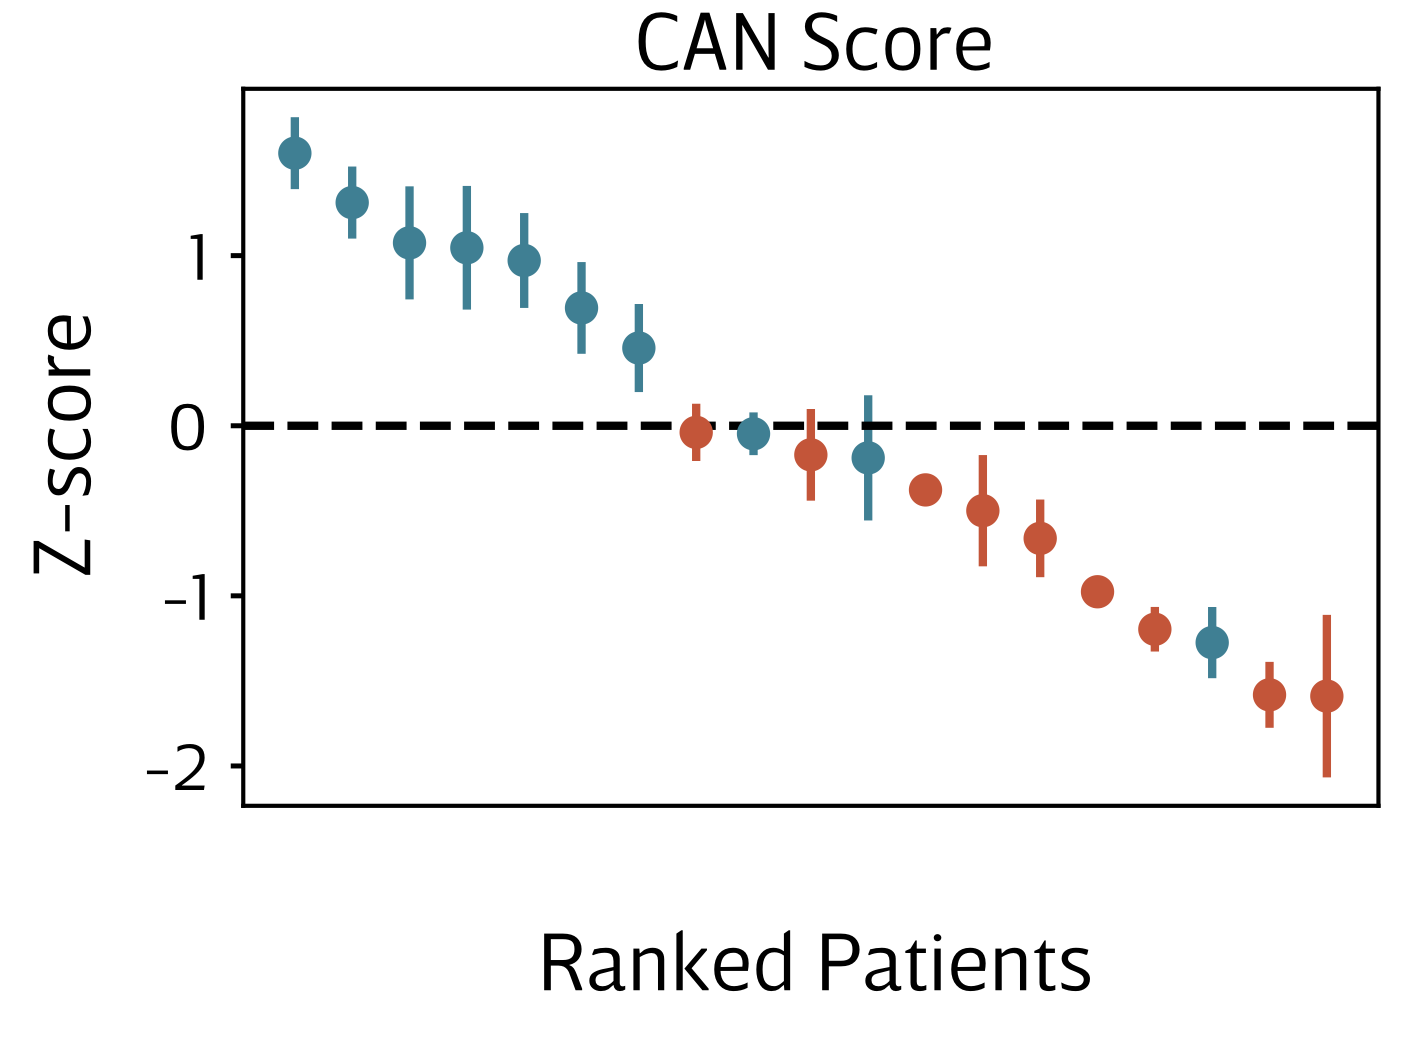

In [21]:
fig = plt.figure()

can_dists = can_means.assign(distance=can_means.SignalDifference - can_boundary)

sns.stripplot(
    data=can_dists,
    x="Sample",
    y="distance",
    hue="Phenotype",  # legend=False,
    hue_order=["Viral", "Bacterial"],
    order=sample_order,
    s=2**2,
    palette=palette,
)
plt.legend().remove()

# Plot the means +/- 95% CI
lines = (
    can_dists["distance"].values[:, None]
    + 1.96 * np.array([[-1, +1]]) * can_stds["SignalDifference"].values[:, None]
)
x = np.tile(np.arange(len(sample_order)), [2, 1])

is_bac = can_dists["Phenotype"] == "Bacterial"
is_vir = can_dists["Phenotype"] == "Viral"

for idx, color in zip([is_vir, is_bac], palette):
    plt.plot(x[:, idx], lines[idx, :].T, color=color)

ax = plt.gca()
ax.set_xticks([])
ax.set_xlabel("\nRanked Patients")
ax.set_ylabel("FAM-HEX")
ax.set_ylabel("Z-score")
ax.axhline(0, color="black", linestyle="--", linewidth=1)


plt.title("CAN Score", fontname="BreveSansText-Light", fontsize=10, pad=2)
format_fig(fig, figsize=figsize, mar_l=0.3, mar_t=0.2, mar_b=0.55)


savefig(fig, alias="bold_pheasant", display_width_inches=0.5)

Saving fig_nan__bold_pheasant__alt in /home/john/projects/can-manuscript/fig_5__happy_jaguar/graphics: [.svg] [.png] done


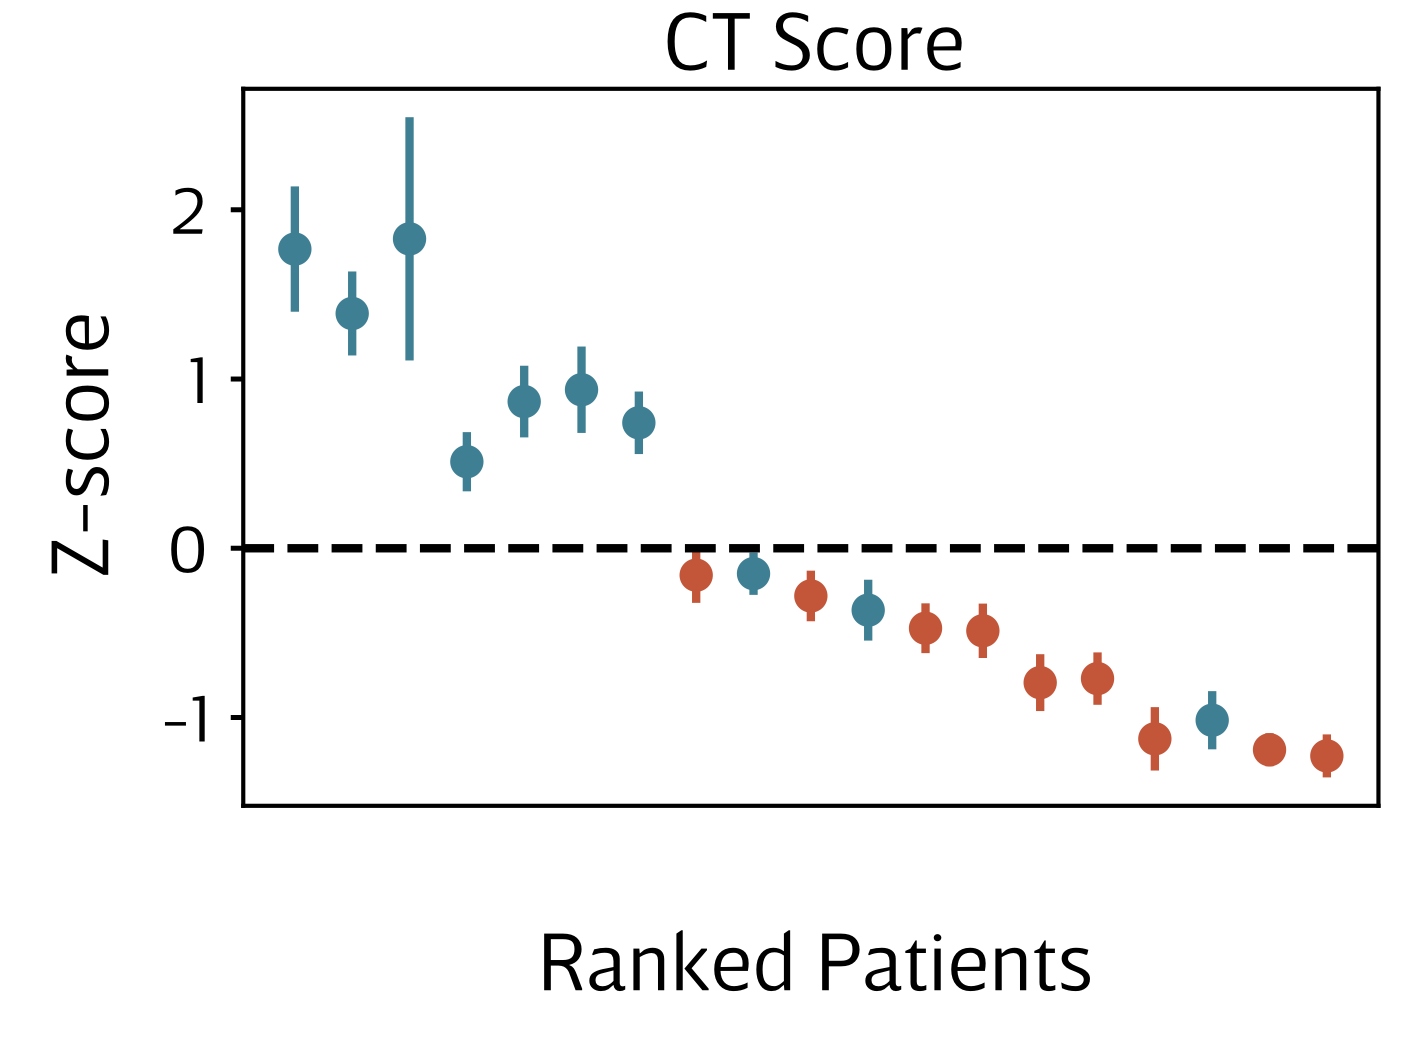

In [22]:
fig = plt.figure()

ct_dists = CTs_mean_sd.set_index("Sample").loc[sample_order, :].reset_index()

μ = ct_dists.distance.mean()
σ2 = ct_dists.distance.std()
ct_dists.distance -= μ
ct_dists.distance /= σ2

ct_dists.distance_sd /= σ2

sns.stripplot(
    data=ct_dists,
    x="Sample",
    y="distance",
    hue="Phenotype",  # legend=False,
    hue_order=["Viral", "Bacterial"],
    order=sample_order,
    s=2**2,
    palette=palette,
)
plt.legend().remove()

# Plot the means +/- standard deviations
lines = (
    ct_dists.distance.values[:, None]
    + 1.96 * np.array([[-1, +1]]) * ct_dists.distance_sd.values[:, None]
)
x = np.tile(np.arange(len(sample_order)), [2, 1])

is_bac = ct_dists["Phenotype"] == "Bacterial"
is_vir = ct_dists["Phenotype"] == "Viral"

for idx, color in zip([is_vir, is_bac], palette):
    plt.plot(x[:, idx], lines[idx, :].T, color=color)

ax = plt.gca()
ax.set_xticks([])
ax.set_xlabel("\nRanked Patients")
ax.set_ylabel("FAM-HEX")
ax.set_ylabel("Z-score")
ax.axhline(0, color="black", linestyle="--", linewidth=1)


plt.title("CT Score", fontname="BreveSansText-Light", fontsize=10, pad=2)
format_fig(fig, figsize=figsize, mar_l=0.3, mar_t=0.2, mar_b=0.55)


savefig(fig, alias="bold_pheasant", extra="alt", display_width_inches=0.5)

Saving fig_5E__tubular_porpoise in /home/john/projects/can-manuscript/fig_5__happy_jaguar/graphics: [.svg] [.png] done


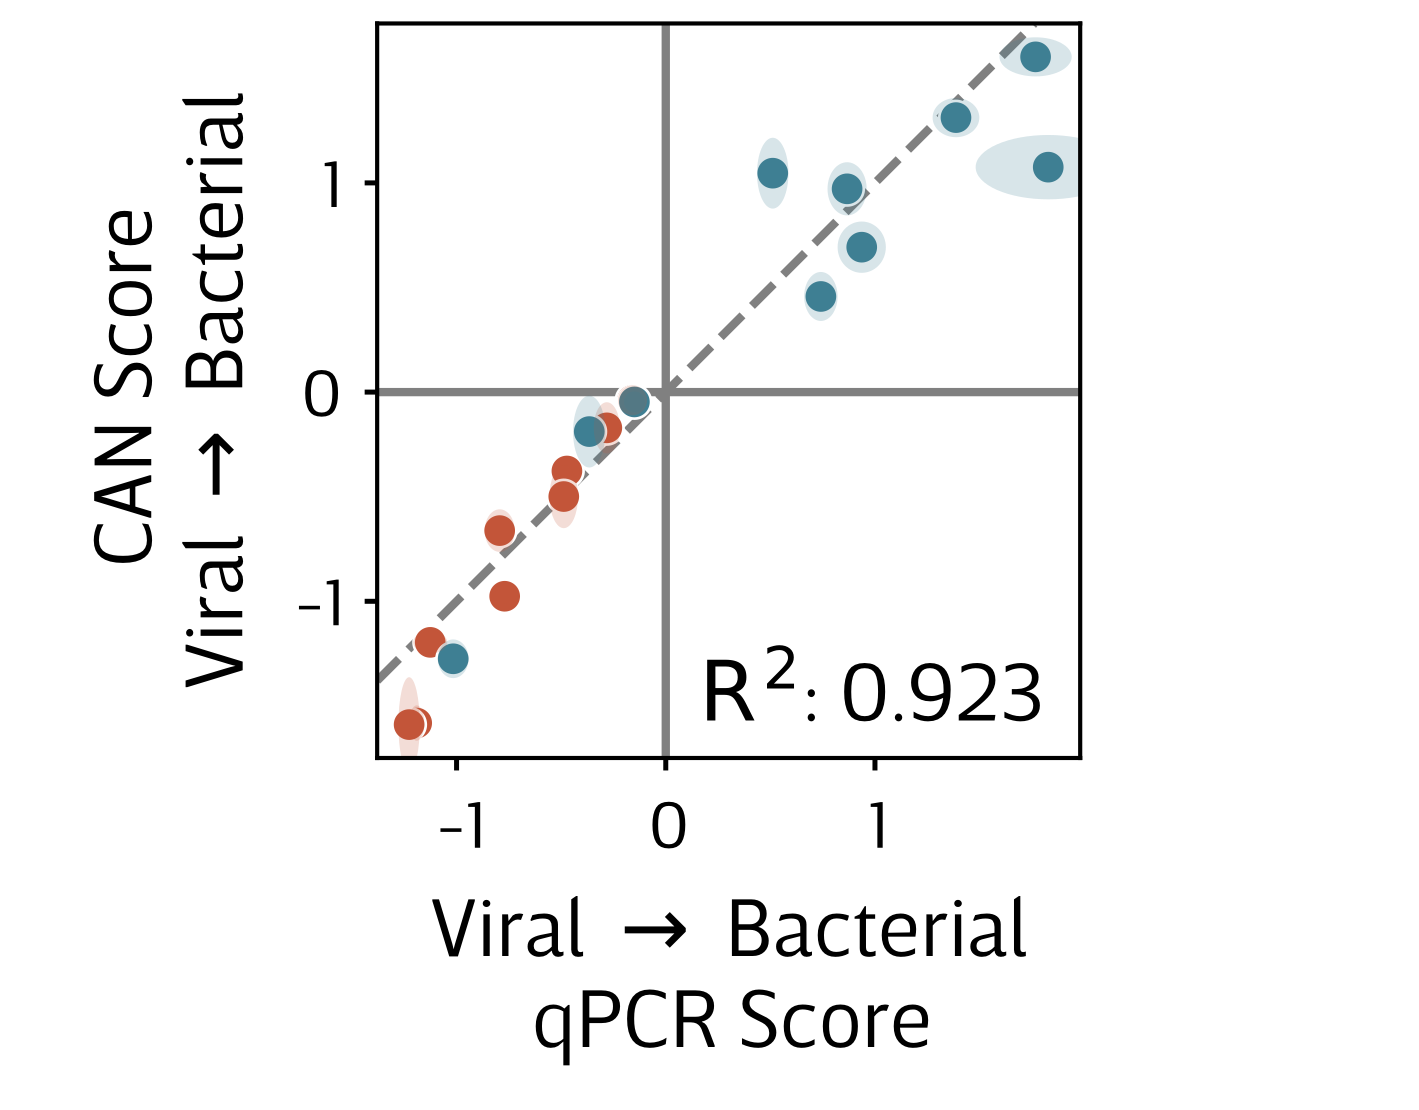

In [43]:
all_dists = (
    can_dists[["Sample", "Phenotype", "distance"]]
    .rename(columns={"distance": "can_dist"})
    .merge(
        can_stds[["Sample", "Phenotype", "SignalDifference"]].rename(
            columns={"SignalDifference": "can_dist_sd"}
        )
    )
    .merge(
        ct_dists[["Sample", "Phenotype", "distance", "distance_sd"]].rename(
            columns={"distance": "ct_dist", "distance_sd": "ct_dist_sd"}
        )
    )
)

discordant = (all_dists.can_dist > 0) ^ (all_dists.ct_dist > 0)

plt.figure()
g = sns.scatterplot(
    data=all_dists,  # [~discordant],
    x="ct_dist",
    y="can_dist",
    hue="Phenotype",
    hue_order=["Viral", "Bacterial"],
    palette=palette,
    s=4**2,
)

plt.legend().remove()
fig = plt.gcf()
ax = plt.gca()

xl = ax.get_xlim()
yl = ax.get_ylim()
l = max(xl[0], yl[0])
u = min(xl[1], yl[1])


from matplotlib.patches import Ellipse, Rectangle
from scipy.stats import linregress

for Dx, color in zip(["Viral", "Bacterial"], palette):
    these = all_dists[all_dists.Phenotype == Dx]

    for _, row in these.iterrows():
        ellipse = Ellipse(
            xy=(
                row.ct_dist,
                row.can_dist,
            ),
            width=row.ct_dist_sd * 1.96,
            height=row.can_dist_sd * 1.96,
            fc=color,
            alpha=0.2,
        )
        ax.add_patch(ellipse)

ax.plot([l, u], [l, u], ls="--", c=".5", zorder=-1)
ax.axvline(0, color=".5", linestyle="-", linewidth=1, zorder=-1)
ax.axhline(0, color=".5", linestyle="-", linewidth=1, zorder=-1)
ax.set_xlim(xl)
ax.set_ylim(yl)
ax.set_xlabel(r"Viral $\rightarrow$ Bacterial" + "\nqPCR Score")
ax.set_ylabel("CAN Score\n" + r"Viral $\rightarrow$ Bacterial")
ax.set_aspect("equal")

reg = linregress(all_dists.ct_dist, all_dists.can_dist)

xy = (np.diff(xl) * 0.95 + xl[0], np.diff(yl) * 0.05 + yl[0])
ax.annotate(f"$R^2$: {reg.rvalue**2:0.3f}", xy=xy, ha="right")

format_fig(fig, figsize=(width, height+0.1), mar_l=0.2, mar_t=0.05, mar_r = 0.15, mar_b=0.75)

savefig(fig, alias="tubular_porpoise", display_width_inches=0.5)

In [24]:
from scipy.stats import wilcoxon

# Perform the Wilcoxon signed-rank test
stat, p_value = wilcoxon(
    all_dists.can_dist_sd, all_dists.ct_dist_sd, alternative="two-sided"
)

# Print the results
print(f"Wilcoxon signed-rank statistic: {stat}")
print(f"P-value: {p_value}")

Wilcoxon signed-rank statistic: 61.0
P-value: 0.18186569213867188


Saving fig_5F__sharp_quail in /home/john/projects/can-manuscript/fig_5__happy_jaguar/graphics:

 [.svg] [.png] done


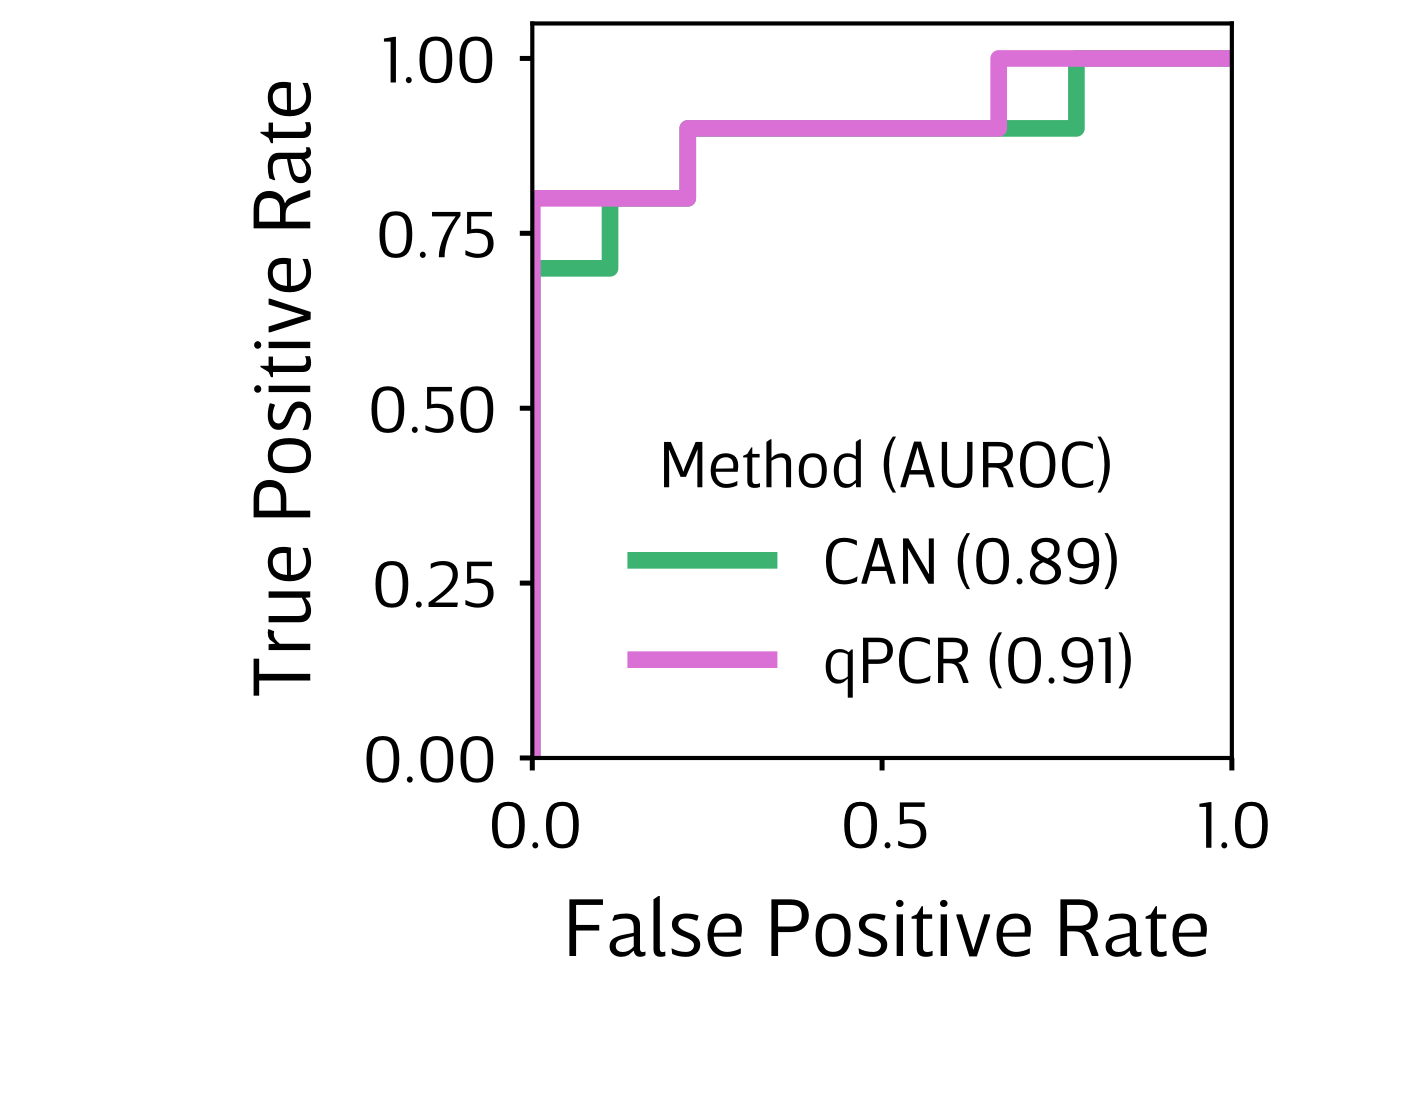

In [25]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for CAN distance
fpr_can, tpr_can, thresholds_can = roc_curve(
    all_dists["Phenotype"] == "Bacterial", all_dists["can_dist"]
)
roc_auc_can = auc(fpr_can, tpr_can)

# Calculate ROC curve and AUC for CT distance
fpr_ct, tpr_ct, thresholds_ct = roc_curve(
    all_dists["Phenotype"] == "Bacterial", all_dists["ct_dist"]
)
roc_auc_ct = auc(fpr_ct, tpr_ct)

# Plot ROC curves
fig = plt.figure()
ax = plt.gca()
ax.plot(
    fpr_can,
    tpr_can,
    color="mediumseagreen",  # "darkorange",
    lw=2,
    label=f"CAN ({roc_auc_can:0.2f})",
)
ax.plot(
    fpr_ct,
    tpr_ct,
    color="orchid",  # "cornflowerblue",
    lw=2,
    label=f"qPCR ({roc_auc_ct:0.2f})",
)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
# ax.set_title("ROC Curves", fontname="BreveSansText-Light", fontsize=10, pad=2)
ax.legend(loc="lower center", fontsize=8, frameon=False, title='Method (AUROC)', title_fontsize =8)
ax.set_aspect('equal')
format_fig(fig, figsize=(width, height+0.1), mar_l=0.5, mar_t=0.05, mar_b=0.75)
# plt.show()

savefig(fig, alias="sharp_quail", display_width_inches=0.5)